# NTDS Project

Team members: 
* Armand Boschin
* Bojana Ranković
* Quentin Rebjock

As a reminder, this is a reminder of the project proposal:

***Graph:*** Wikipedia hyperlink network

***Problem:*** Does the structure of the graph bears info on the content of the nodes ? We would like to find out if it is possible to detect communities of pages just by looking at the hyperlink connections and match these communities with real-world data such as categories of the pages.

***Steps of the project:***
* Scraping the Wikipedia hyperlink network. Start from one node and get the pages as far as 2 or 3 hops depending on the number of nodes we get.
* Try to apply spectral clustering in order to detect clusters of pages.
* Visualize the clusters to match them with real-world categories (using some of the tools from the last guest lecture).
* Model the network by a random graph/scale-free network/something else in order to try to retrieve some of its characteristics.
* Improve the community detection using for example the Louvain algorithm.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
import networkx as nx
import pickle

from scipy import sparse, linalg
from bs4 import BeautifulSoup

%matplotlib inline
warnings.simplefilter(action='ignore', category=UserWarning)

# 1) Data Acquisition

We want to acquire a sub-network of the Wikipedia hyperlink network. In such a graph, each node is a Wikipedia page and there is a link between node a and node b is there is a link to page b on page a. This is a directed network but we will make it undirected later on.

The process of the acquisition is the following : 
* Start from an arbitrary root node (prefer and ambiguous page in order to get as many different communities as possible).
* Explore the page to get the intra-wiki links and get first nodes.
* For each first node, explore the intra-wiki links to get the second nodes.

We chose to scrap directly the HTML code of wikipedia pages rather than using the standard Wikipedia API because this API cannot fetch disambiguation pages natively and those are some pages we are interrested in as the list a large variety of links (more on that later). 

Moreover, scraping the HTML code of pages is really easy and straigtforward when we are simply looking for intra wiki links.

On Wikipedia pages, all the links are contained in the following HTML structure of tags: 
```html
<li>
    <a href:''>
    </a>
</li>
```
This is what is used in the following function that finds the intra Wiki links on a given page.

In [ ]:
def find_inner_links(page_link):
    """
    :param page_link: url of the current page
    :return: list of the intra wiki urls contained in the current page
    """
    links = []
    # Get the HTML code of the page.
    soup = BeautifulSoup(requests.get('https://en.wikipedia.org'+page_link).text)
    # Look for all the <li> tags contained in the page.
    li_tags = soup.find_all('li')  
    for li_tag in li_tags:
        # Look for all the <li> tags contained the current <a> tag.
        a_tags = li_tag.find_all('a')
        for a_tag in a_tags:
            try:
                # Check if the current <a> tag is an intra wiki link.
                if '/wiki/' == a_tag['href'][0:6]:
                    links.append(a_tag['href'])
            except KeyError:
                # In this case the <a> tag is not a link.
                pass
    return links

We use as `root_node` the disambiguation page [Jaguar](https://en.wikipedia.org/wiki/Jaguar_(disambiguation) as it lists a really wide variety of themes (animals, cars, music, films, weapons...). The aim is to scrap pages from as many different communities as possible.

In [53]:
root_node = '/wiki/Jaguar_(disambiguation)'

In [ ]:
neighbors = {}  # This dict stores for each page the list of its neighbors.

In [ ]:
first_nodes = set(find_inner_links(root_node))
neighbors[root_node] = first_nodes

In [ ]:
second_nodes = set()
for link in first_nodes:
    tmp = find_inner_links(link)
    neighbors[link] = tmp
    second_nodes = second_nodes.union(set(tmp))

Create the set of all nodes.

In [ ]:
nodes = first_nodes.union(second_nodes)
nodes.add(origin)

Look for connections between second nodes and the rest of the nodes.

In [ ]:
counter = 0
for link in second_nodes:
    counter += 1
    if counter % 100 == 0:
        print('{}/{}'.format(counter, len(second_nodes)))
    tmp = find_inner_links(link)
    neighbors[link] = list(set(tmp).intersection(nodes))

#### Creating pickle files

As the scraping of the network takes quite some time (especially getting the inner connections), we store the results in pickle files.

In [2]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_obj(nodes, 'nodes')
save_obj(first_nodes, 'first_nodes')
save_obj(second_nodes, 'second_nodes')
save_obj(neighbors, 'neighbors')

In [3]:
nodes = load_obj('nodes')
first_nodes = load_obj('first_nodes')
second_nodes = load_obj('second_nodes')
neighbors = load_obj('neighbors')

### Network creation

Let's convert the collected network into a networkx instance which is quite handy to manipulate.

Let's make it undirected as well.

In [4]:
g = nx.Graph(neighbors)

In [5]:
nx.write_gml(g, "base_graph.gml")

# 2) Data Exploration

In this part of the notebook, we provide some indicators of the data in order to understand what we'll be working on.

TODO: properties of the collected network

* Adjacency matrix
* Degrees distribution
* Average degree
* Diameter of the collected network
* (Pruning the collected network if necessary ?)
* Visualization of the network

In [5]:
print('Total number of nodes : {}'.format(len(nodes)))
print('Number of first nodes : {}'.format(len(first_nodes)))
print('Number of second nodes : {}'.format(len(second_nodes)))
print('Number of edges : {}'.format(np.sum([len(n) for n in neighbors.values()])))

Total number of nodes : 8745
Number of first nodes : 73
Number of second nodes : 8745
Number of edges : 859184


#### Adjacency Matrix

In [5]:
adj = nx.adjacency_matrix(g)

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)

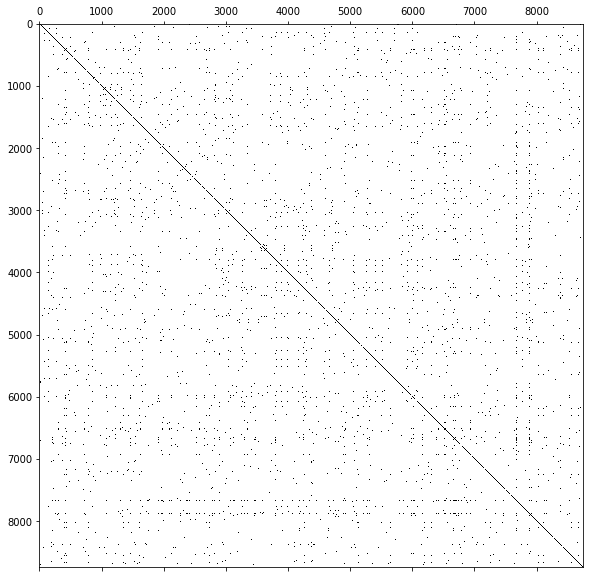

In [12]:
plt.spy(adj.todense())

Check if it's symmetric :

In [13]:
(adj != adj.T)

<8745x8745 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Degrees distribution

As there are some clear outliers making the visualization difficult, we can truncate the degrees or just use a box plot.

In [10]:
degrees = np.array(adj.sum(axis=1))
degrees_truncated = degrees[degrees < 700]

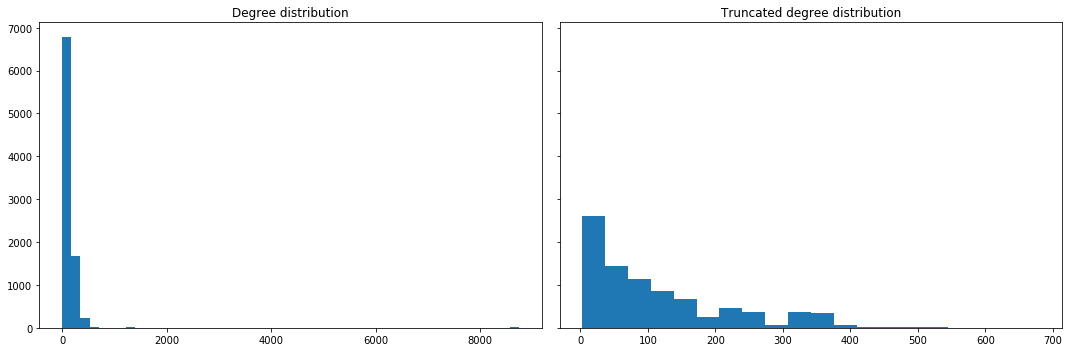

In [43]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree distribution')
#sns.distplot(degrees, bins=50, ax=ax[0, 0])
ax[0].hist(degrees, bins=50)

ax[1].set_title('Truncated degree distribution')
#sns.distplot(degrees_truncated, bins=20, ax=ax[0, 1])
ax[1].hist(degrees_truncated, bins=20)

plt.tight_layout()
plt.show()

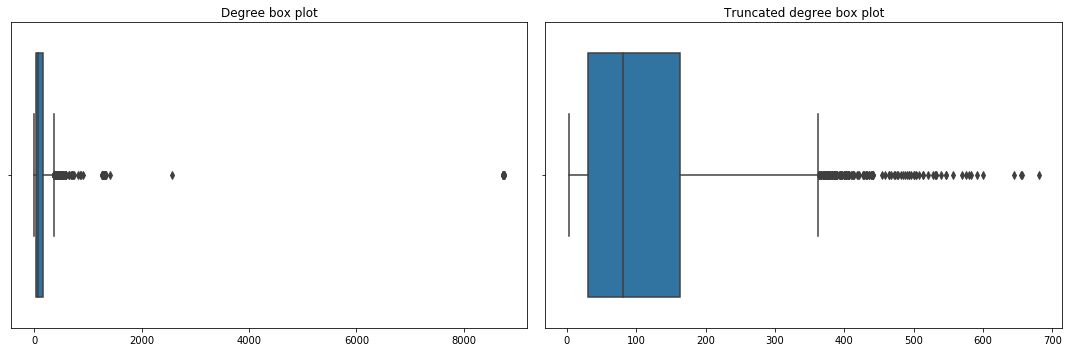

In [44]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax[0].set_title('Degree box plot')
sns.boxplot(degrees, ax=ax[0])

ax[1].set_title('Truncated degree box plot')
sns.boxplot(degrees_truncated, ax=ax[1])

plt.tight_layout()
plt.show()

#### Average degree

In [47]:
avg_degree = np.mean(degrees)
print('The average degree of the network is {}.'.format(np.round(avg_degree, 2)))

The average degree of the network is 133.41.


#### Diameter

In [ ]:
#Didn't end after 1 hour of computation...
diameter = nx.diameter(g)
print('The diameter of the network is {}.'.format(diameter))

#### Visualization

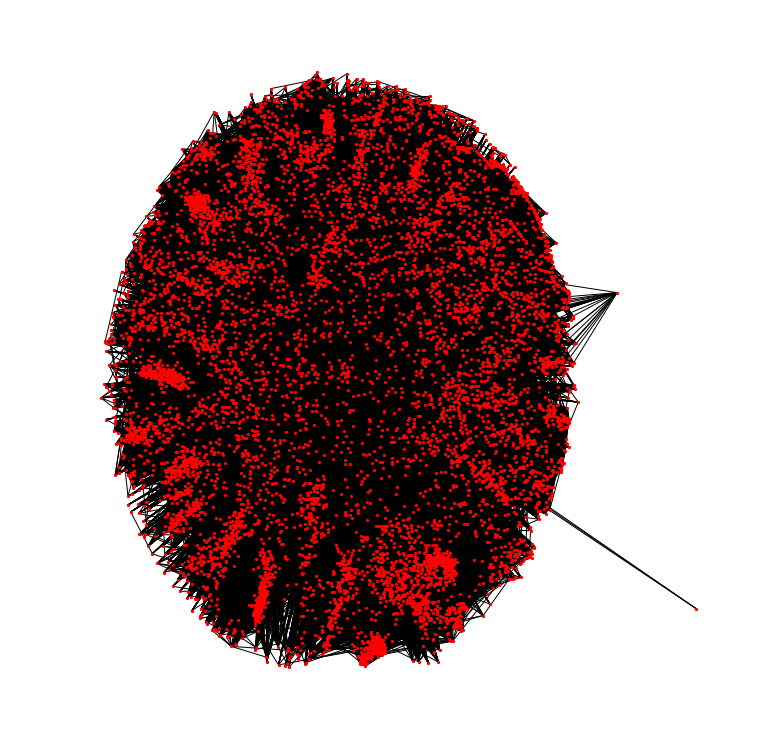

In [48]:
nx.draw(g, node_size=5)

# 3) Data Exploitation

We will try to use the collected data to answer our problem which is: 
 **Can we isolate communities of pages just by looking at the hyperlink graph ? **
 
The steps are the following :
 * Spectral clustering
 * Visualization of the communities
 * Modelization of the network
 * Improvement of the clustering ?
 
 
 * Visualize a random walk on the graph ? Signal processing on the graph. If we take a uniform signal (uniform distribution) and let the signal evolve randomly, what do we get ? Get we get hubs ?

## Spectral Clustering

In [61]:
laplacian = np.diag([int(d) for d in list(adj.sum(axis=1))]) - adj

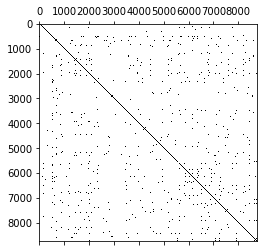

In [62]:
plt.spy(laplacian)

In [55]:
eigenvalues, eigenvectors = linalg.eigh(laplacian, eigvals=(0, 39))

In [57]:
centroids, labels = scipy.cluster.vq.kmeans2(eigenvectors, 40)

In [59]:
cc = [0 for i in range(40)]
for i in labels:
    cc[i] += 1

In [60]:
cc

[1,
 6,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 3,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 7,
 0,
 1,
 1,
 8692,
 1,
 3,
 0,
 1,
 3,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 3,
 3,
 1,
 0]

## Modelisation of the network

In [65]:
def plot_degree_distr(graph):
    d = list(dict(graph.degree()).values())
    plt.hist(list(d), bins = 16);
    plt.ylabel('Number of vertices')
    plt.xlabel('Degree')
    plt.title('Degree distribution')
    plt.show()

In [67]:
nNodes = len(g.nodes())
nEdges = g.size()

print('The network has {0} nodes and {1} edges.'.format(nNodes, nEdges))

The network has 8745 nodes and 587427 edges.


We would like to create a model with approximatively the same number of nodes and edges, and with the same degree distribution.

#### Erdős–Rényi graph

In [52]:
p = 2*nEdges/nNodes/(nNodes - 1)
p

0.015364340987949199

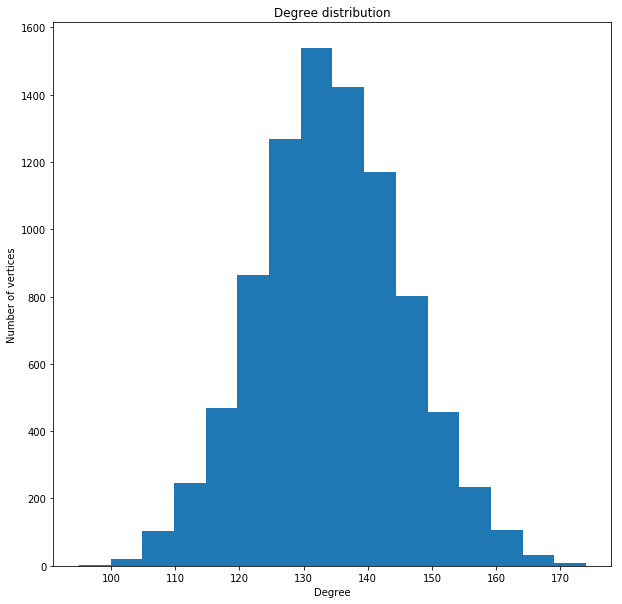

In [66]:
er = nx.erdos_renyi_graph(nNodes, p)

plot_degree_distr(er)

It clearly doesn't match the distribution of our network.

#### Barabási-Albert

In [77]:
ba=nx.barabasi_albert_graph(nNodes, 68)

print('This Barabási-Albert network has {} edges.'.format(ba.size()))

This Barabási-Albert network has 590036 edges.


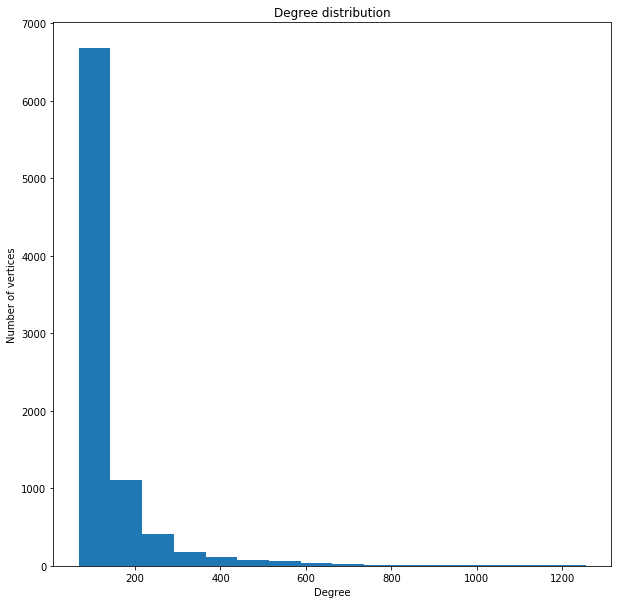

In [78]:
plot_degree_distr(ba)

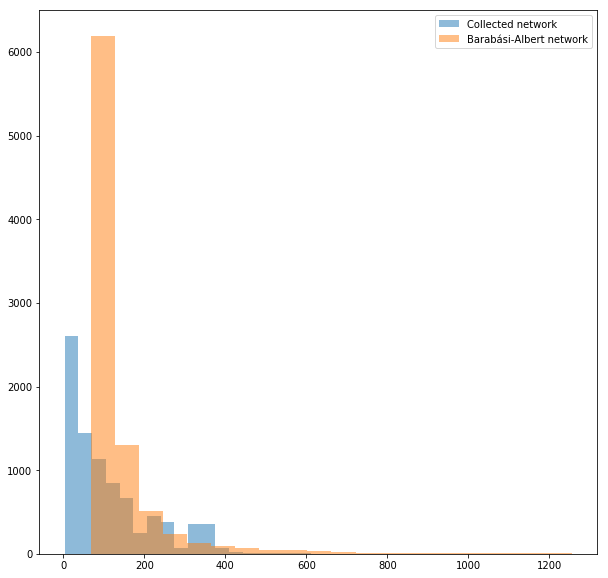

In [88]:
ba_degrees = list(dict(ba.degree()).values())


plt.hist(degrees_truncated, 20, alpha=0.5, label='Collected network')
plt.hist(ba_degrees, 20, alpha=0.5, label='Barabási-Albert network')
plt.legend(loc='upper right')
plt.show()

#### Giant components

# 4) Louvain community detection

In [18]:
import community
import wikipedia
from tqdm import tqdm
import json
import wikipediaapi

In [11]:
G = nx.read_gml('data/base_graph.gml')
partition = community.best_partition(G)


In [12]:
community2color = {
    0: sns.xkcd_rgb["peach"],
    1: sns.xkcd_rgb["powder blue"],
    2: sns.xkcd_rgb["light pink"],
    3: sns.xkcd_rgb["chocolate"],
    4: sns.xkcd_rgb["orange"],
    5: sns.xkcd_rgb["magenta"],
    6: sns.xkcd_rgb["purple"],
    7: sns.xkcd_rgb["blue"],
    8: sns.xkcd_rgb["deep blue"],
    9: sns.xkcd_rgb["sky blue"],
    10: sns.xkcd_rgb["olive"],
    11: sns.xkcd_rgb["seafoam green"],
    12: sns.xkcd_rgb["tan"],
    13: sns.xkcd_rgb["mauve"],
    14: sns.xkcd_rgb["hot pink"],
    15: sns.xkcd_rgb["pale green"],
    16: sns.xkcd_rgb["indigo"],
    17: sns.xkcd_rgb["lavender"],
    18: sns.xkcd_rgb["eggplant"],
    19: sns.xkcd_rgb["brick"],
}

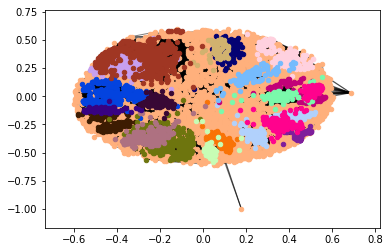

In [13]:
position = nx.spring_layout(G)

for comunity in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == comunity]
    nx.draw_networkx_nodes(G, position, list_nodes, node_size = 20,
                                node_color = community2color[comunity])


nx.draw_networkx_edges(G, position, alpha=0.5)
plt.show()


In [16]:
mod = community.modularity(partition,G)
print(mod)

0.6801028172787953


In [41]:
def find_node_category(page_link):
    """
    :param page_link: url of the current page
    :return: first and most important category the page belongs to
    """
    
    soup = BeautifulSoup(requests.get('https://en.wikipedia.org'+page_link).text)
    category_links = soup.find("div", {"class": "mw-normal-catlinks"})
    
    
    # each page contains multiple categories listed in li tags, we are interested in the first one
    
    for ultag in category_links.find_all('ul'):
        for litag in ultag.find_all('li')[0]:
            return litag.text
    
find_node_category('/wiki/Jaguar_(disambiguation)')

'Disambiguation pages'

In [42]:
node2category={}
for node in tqdm(G.nodes):
    try:
        node2category[node]=find_node_category(node)
    except:
        node2category[node]='Unknown'

100%|██████████| 8745/8745 [48:56<00:00,  2.98it/s]


In [43]:
node2category

{'/wiki/Jaguar_(disambiguation)': 'Disambiguation pages',
 '/wiki/Talk:Jaguar_(disambiguation)': 'WikiProject Disambiguation pages',
 '/wiki/The_Way_You_Look_Tonight': '1930s jazz standards',
 '/wiki/Portal:Contents': 'Wikipedia directories',
 '/wiki/Jaguar_(Marvel_Comics)': 'Lists of Marvel Comics characters',
 '/wiki/Special:Random': 'Bathycongrus',
 '/wiki/South_American_Jaguars': 'International rugby union teams',
 '/wiki/Jaguar_(software)': 'Computational chemistry software',
 '/wiki/French_destroyer_Jaguar': '1923 ships',
 '/wiki/Special:MyTalk': 'Unknown',
 '/wiki/Jaguar_(band)': 'English heavy metal musical groups',
 '/wiki/Jaguar!': 'Operating roller coasters',
 '/wiki/SS_Empire_Ballad': '1941 ships',
 '/wiki/Jaguar_warrior': 'Soldiers',
 '/wiki/Portal:Featured_content': 'Wikipedia featured content',
 '/wiki/Jaguar_(Insurgent_Comix)': 'Fictional American people of Mexican descent',
 '/wiki/Special:SpecialPages': 'Unknown',
 '/wiki/Jaguar_(novel)': '1997 American novels',
 '/wi

In [44]:
def save_categories(node2category):
    with open('data/node_categories.json', 'w') as fp:
        json.dump(node2category, fp)
save_categories(node2category)

In [14]:
def load_categories(category_file):
    with open(category_file) as json_data:
        return json.load(json_data)
node2category = load_categories('data/node_categories.json')

In [48]:
nx.set_node_attributes(G, partition, 'community')
nx.set_node_attributes(G, node2category, 'category')


In [50]:
G.node['/wiki/Jaguar_(novel)']

{'category': '1997 American novels', 'community': 0}

In [51]:
nx.write_gml(G, "data/full_graph.gml")


In [ ]:
G = nx.read_gml("data/full_graph.gml")

Communities by Louvain.

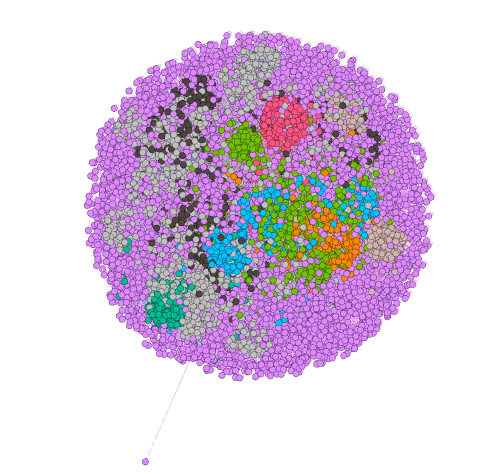

Communities by category


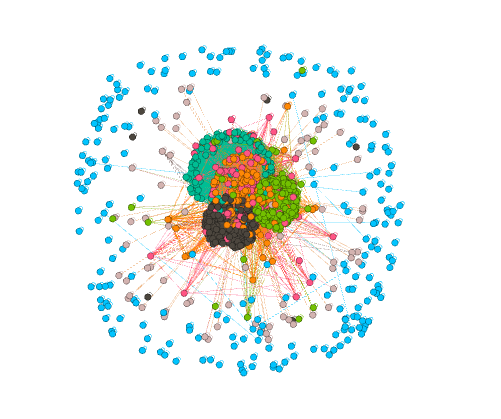

In [89]:
def find_inner_links(page_name):
    """
    :param page_name: name of the current page
    :return: list of the intra wiki urls contained in the current page
    """
    # Get the HTML code of the page.
    links = []
    page = wiki_wiki.page(page_name)
    # Look for all the <li> tags contained in the page.
    page_titles = list(page.links.keys())
    for title in page_titles:
        if wiki_wiki.page(title).exists():
            links.append(wiki_wiki.page(title).fullurl[24:])
            
    return links

In [90]:
find_inner_links('Argentina Jaguars')

['/wiki/1965_Argentina_rugby_union_tour_of_Rhodesia_and_South_Africa',
 '/wiki/1971_Argentina_rugby_union_tour_of_South_Africa',
 '/wiki/1973_Argentina_rugby_union_tour_of_Ireland_and_Scotland',
 '/wiki/1975_Argentina_rugby_union_tour_of_France',
 '/wiki/1976_Argentina_rugby_union_tour_of_Wales_and_England',
 '/wiki/1978_Argentina_rugby_union_tour_of_Britain,_Ireland_and_Italy',
 '/wiki/1979_Argentina_rugby_union_tour_of_New_Zealand',
 '/wiki/1982_Argentina_rugby_union_tour_of_France_and_Spain',
 '/wiki/1983_Argentina_rugby_union_tour_of_Australia',
 '/wiki/1986_Argentina_rugby_union_tour_of_Australia',
 '/wiki/1988_Argentina_rugby_union_tour_of_France',
 '/wiki/1989_Argentina_rugby_union_tour_of_New_Zealand',
 '/wiki/1990_Argentina_rugby_union_tour_of_British_Isles',
 '/wiki/1991_Rugby_World_Cup_%E2%80%93_Americas_qualification',
 '/wiki/1992_Argentina_rugby_union_tour_of_Europe',
 '/wiki/1994_Argentina_rugby_union_tour_of_South_Africa',
 '/wiki/1995_Argentina_rugby_union_tour_of_Aust

# 5) Conclusion